In [18]:
import numpy as np
import cygnus_lib as cy
import matplotlib.pyplot as plt
import mylib as my
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
%matplotlib inline
x_resolution = y_resolution = 2048
from itertools import combinations
pixelscale  = 0.125 #55e-3 #Orange 0.125 for lemonn mm/pixel

In [19]:

nsigma      = 1
run         = 54
traccia     = 1 #3
cimax       = 130
cimin       = 103# 85
dataSelection = 'BTF'
image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, traccia))
try:
    fileoutm = ("./data/run%d_mean.h5" % (run))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run)
    print ("STOP")

try: 
    fileouts = ("./data/run%d_sigma.h5" % (run))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run)
    print ("STOP")

th_image    = np.round(m_image + nsigma*s_image)

Pedestal mean: 102.94, sigma: 5.15, over th. (130) 59908
Sigma mean: 7.00, sigma: 7.50, over th. (50) 102031


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [20]:
###### avarege NumImage
NumImage = 10 
max_image=np.size(cy.swift_listdir(cy.file2FullPathCygnus(dataSelection, run, 'H5')))
print ("# of Image Files: %d" % (max_image))
for iImg in range(0, NumImage):
    image += cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, iImg))
    print (">>> Image: %d" % (iImg))
image=image/NumImage
print(image.mean(), image.std())

# of Image Files: 91
>>> Image: 0
>>> Image: 1
>>> Image: 2
>>> Image: 3
>>> Image: 4
>>> Image: 5
>>> Image: 6
>>> Image: 7
>>> Image: 8
>>> Image: 9
111.88994336128233 68.17683623432946


In [21]:
image

array([[112.1, 107.6, 110.7, ..., 105.8, 108.7, 111.2],
       [111.3, 111.3, 110.6, ..., 109.3, 104.2, 110.6],
       [107.8, 109.3, 108.9, ...,  99.2, 106. , 107. ],
       ...,
       [111.2, 109.3, 108.8, ..., 110.1, 106.2, 110.3],
       [110.5, 105.2, 174.4, ..., 107.7, 110. , 103.6],
       [110.1, 117.3, 117.3, ..., 113.4, 108. , 110. ]])

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


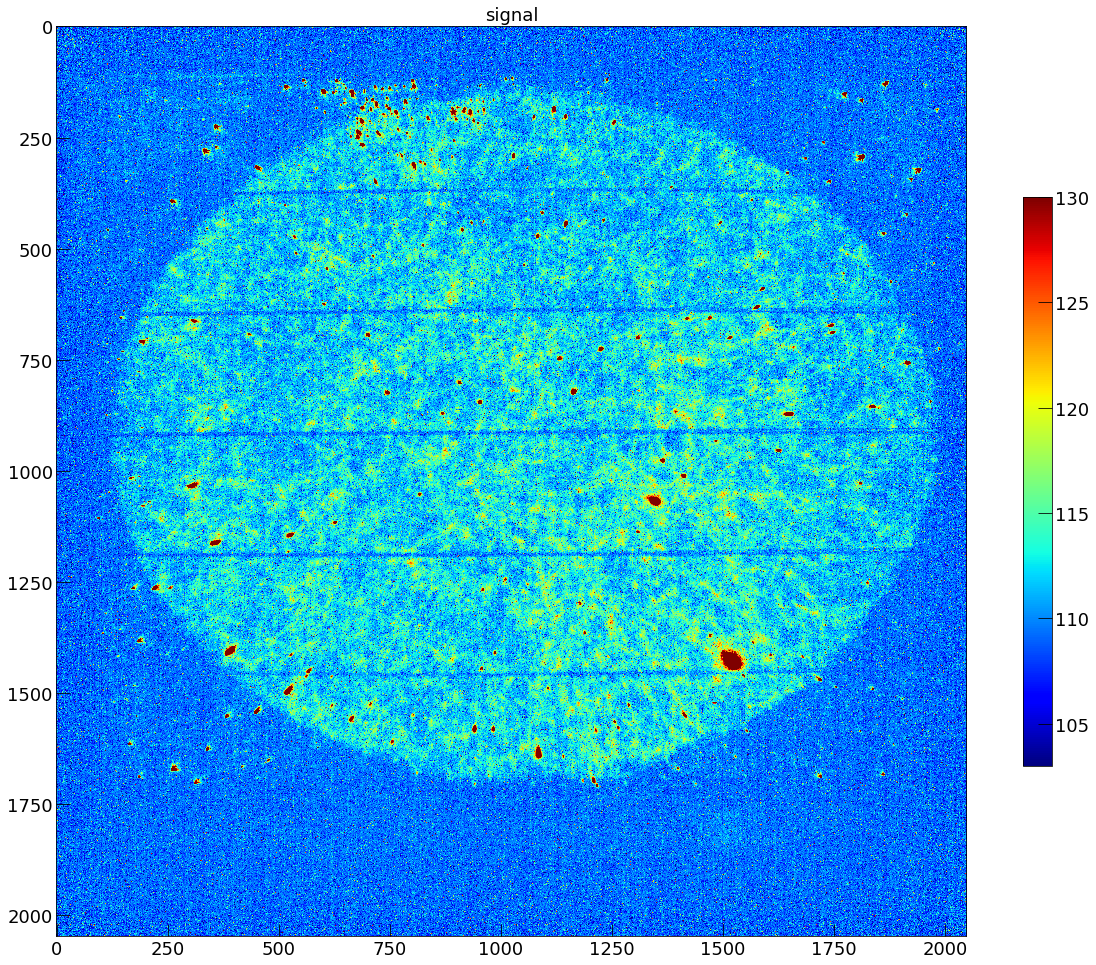

In [22]:
cy.set_atlas_style("large")
plt.imshow(image, vmin=cimin,vmax=cimax, cmap='jet')
plt.colorbar(shrink=0.5)
plt.title("signal")
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


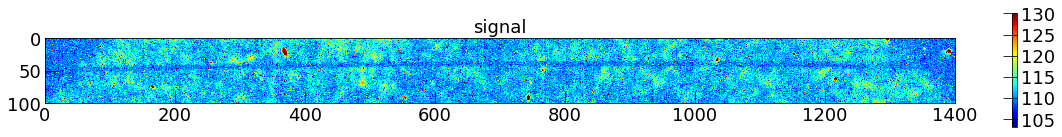

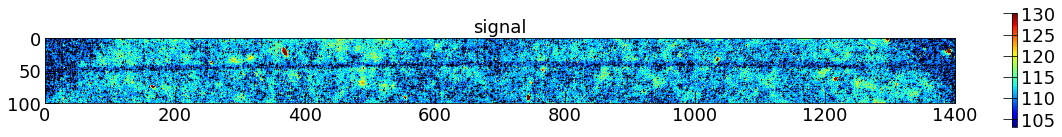

(array([ 41.8922632 , 709.72812726]), array([ 0.00471652, -0.99998888]))


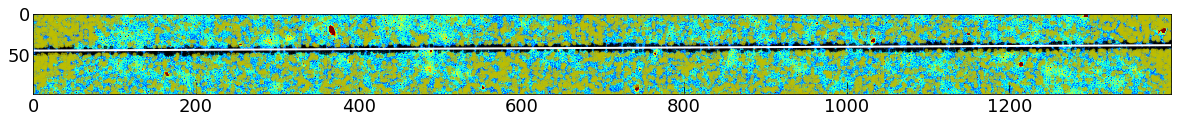

[76682.57965621  1147.4412241  76642.89733988]
Curvature: 1.30e-05


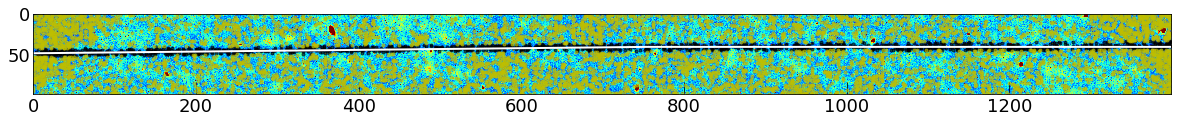

In [23]:
cy.set_atlas_style("large")
#[330:430, 350:1750]
#[600:700, 100:2048]
#[870:950, 100:2048]
#[1150:1230, 100:2048]
#[1400:1500, 350:1750]
imageCutted = image[330:430, 350:1750]
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
plt.colorbar(shrink=0.1)
plt.title("signal")
plt.show()
edges     = (imageCutted < 108)
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
points    = np.array(np.nonzero(edges)).T.astype(float)
plt.plot(points[:,1], points[:,0], "k.", markersize=1)
plt.colorbar(shrink=0.1)
plt.title("signal")
plt.show()
from skimage.measure import LineModelND, CircleModel, ransac

model = LineModelND()
model.estimate(points)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(points, LineModelND, min_samples=2,
                               residual_threshold=5, max_trials=1000)
outliers = inliers == False


line_x = np.arange(0, imageCutted.shape[1])
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)
print(model_robust.params)

fig, ax = plt.subplots()
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
ax.plot(points[inliers, 1], points[inliers, 0], '.k', alpha=0.6,
        label='Inlier data', markersize=6)
ax.plot(points[outliers, 1], points[outliers, 0], '.y', alpha=0.6,
        label='Outlier data', markersize=6)
#ax.plot(line_y, line_x, '-y', label='Line model from all data')
ax.plot(line_y_robust, line_x, '-w', label='Robust line model', linewidth=2)
#ax.legend()
plt.xlim(0,imageCutted.shape[1]-1)
plt.ylim(imageCutted.shape[0]-1,0)
plt.show()

modelc = CircleModel()
modelc.estimate(points)

model_robustc, inliers = ransac(points, CircleModel, min_samples=3,
                               residual_threshold=5, max_trials=1000)

outliers = inliers == False
circle_t = np.linspace(0, 2 * np.pi, 614)
circle_xy = modelc.predict_xy(circle_t)
circle_xy_robust = model_robustc.predict_xy(circle_t)
print(model_robustc.params)
cy, cx, r = model_robustc.params
print("Curvature: %.2e" % (1/r))

fig, ax = plt.subplots()
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')
ax.plot(points[inliers, 1], points[inliers, 0], '.k', alpha=0.6,
        label='Inlier data', markersize=6)
ax.plot(points[outliers, 1], points[outliers, 0], '.y', alpha=0.6,
        label='Outlier data', markersize=6)
#ax.plot(line_y, line_x, '-y', label='Line model from all data')
ax.plot(circle_xy_robust[:,1], circle_xy_robust[:,0], '-w', label='Robust line model', linewidth=2)
plt.xlim(0,imageCutted.shape[1]-1)
plt.ylim(imageCutted.shape[0]-1,0)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


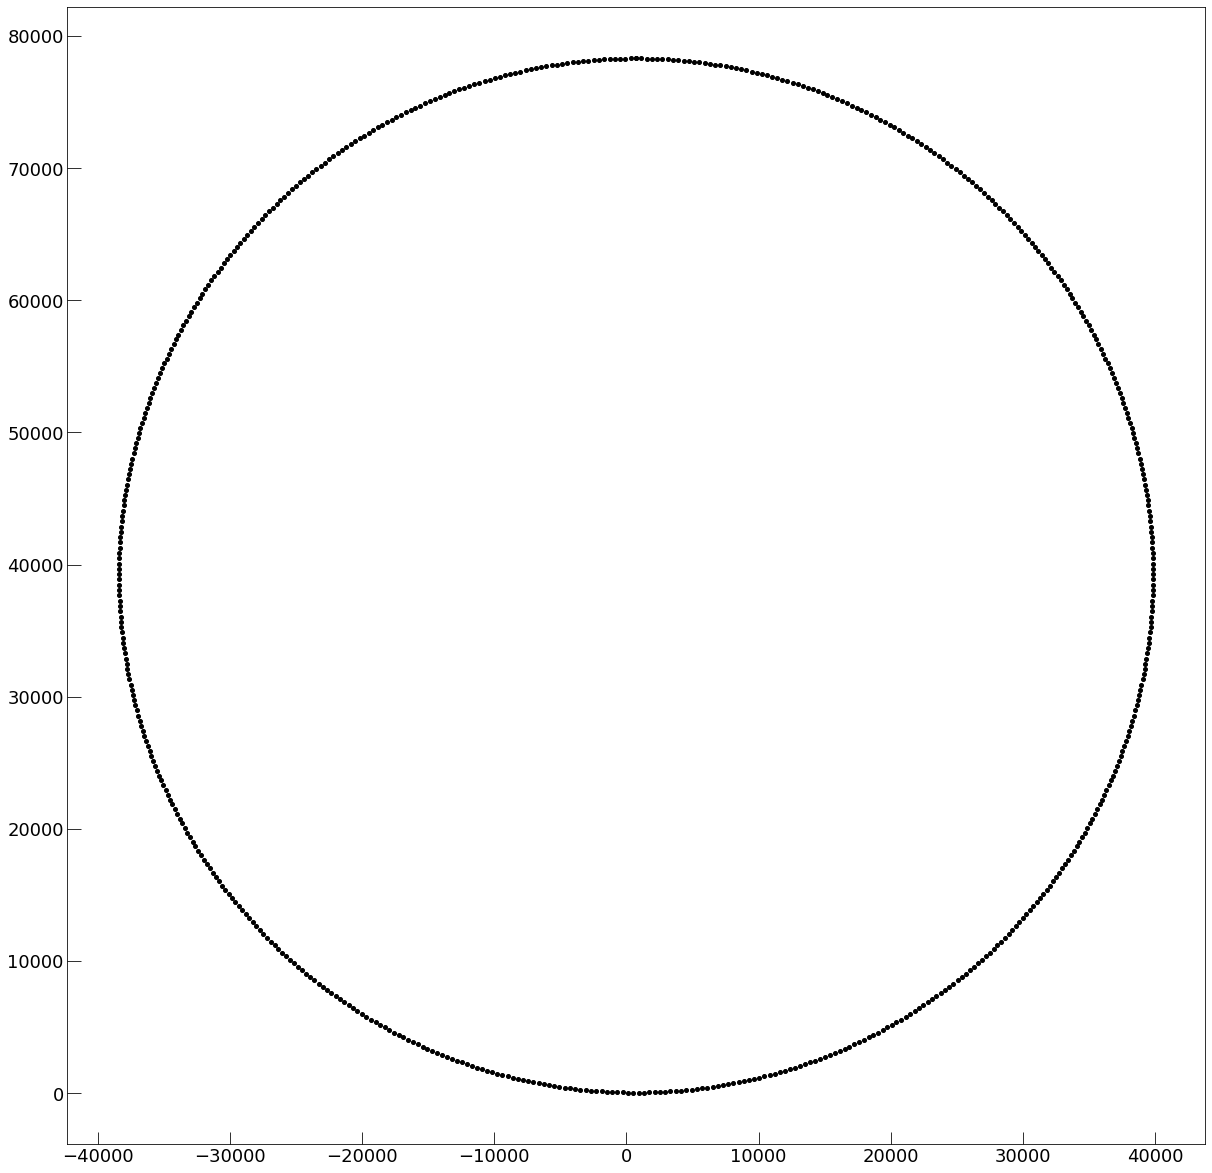

array([78299.85736001,   721.89294338])

In [14]:
plt.plot(circle_xy_robust[:,1], circle_xy_robust[:,0], '.k', label='Robust line model')
plt.show()
circle_xy_robust[0]

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


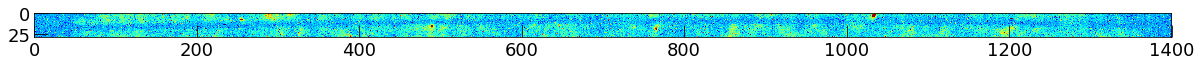

fit error


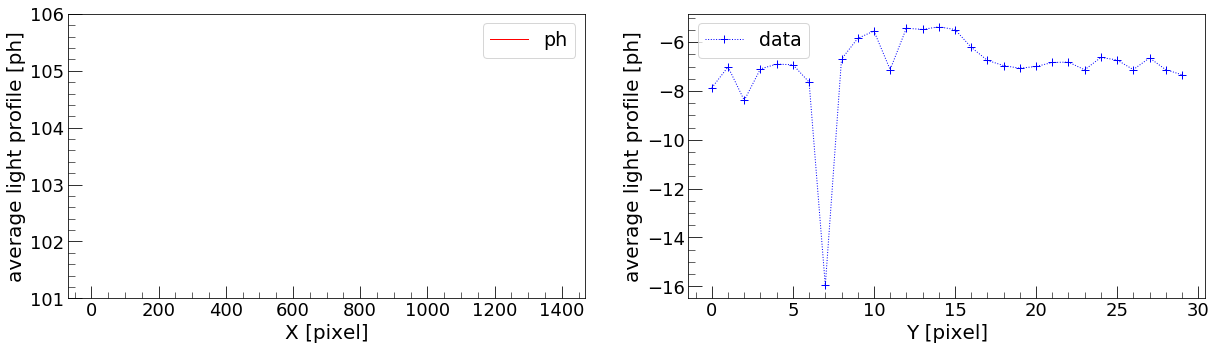

Int light in X: 156743.20 [ph*pixel]
Int light in Y: 3248.53 [ph*pixel]
Light, X: 4547936.65 / Y: 4702295.90 [ph]


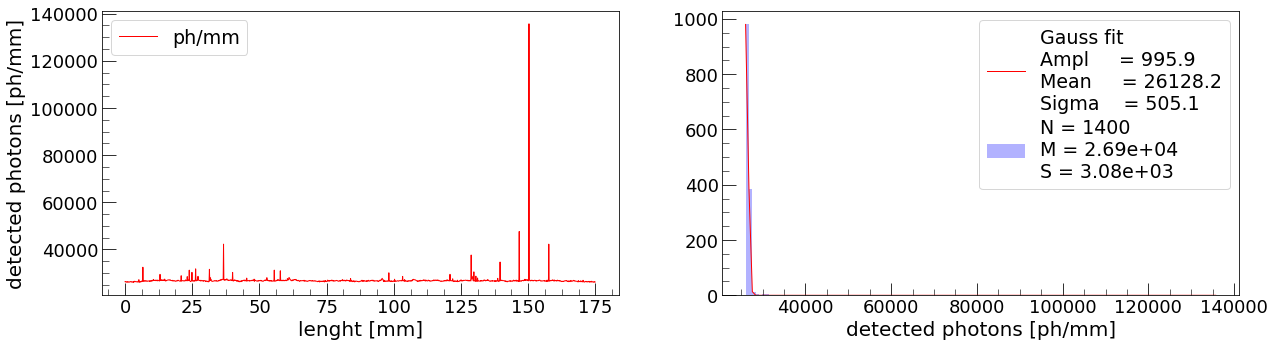

In [220]:

cy.set_atlas_style('long')
# 2 - [360:390, 350:1750]
# 1 - [630:670, 800:1900]
# 0 - [900:940, 100:2048]
#-1 - [1170:1210, 100:2048]
#-2 - [1445:1475, 350:1750]
imageCutted = image[360:390, 350:1750]
plt.imshow(imageCutted, vmin=cimin,vmax=cimax, cmap='jet')

plt.show()
fig, ax = plt.subplots(1,2)
#
Xproj       = np.mean(imageCutted, axis=0)
Yproj       = np.mean(imageCutted, axis=1)

xx          = np.arange(0, imageCutted.shape[1])
xy          = np.arange(0, imageCutted.shape[0])


#

ax[0].plot(xx, Xproj, 'r-', label='ph')
ax[0].set_ylabel('average light profile [ph]')
ax[0].set_xlabel('X [pixel]')
ax[0].minorticks_on()
ax[0].set_ylim(101,106)
ax[0].legend()

x0 = xy.size/2
s0 = 5
a0 = max(Yproj)
ax[1].plot(xy, 105-Yproj, 'b+:', label='data')
try:
    popt,pcov = curve_fit(my.Gauss3, xy, 105-Yproj, p0=[a0, x0, s0])
    ax[1].plot(xy, my.Gauss3(xy, *popt), 'r-',
           label='Gauss fit   \nAmpl     = %.1f\nMean     = %.1f\nSigma   = %.1f' %
           (popt[0], popt[1], popt[2]))
    Afit = popt
except:
    print ("fit error")

ax[1].set_xlabel('Y [pixel]')
ax[1].set_ylabel('average light profile [ph]')
ax[1].minorticks_on()
ax[1].legend()
plt.show()


fig, ax = plt.subplots(1,2)
DDY = np.trapz(Yproj,xy)
DDX = np.trapz(Xproj,xx)
print("Int light in X: %.2f [ph*pixel]" % DDX)
print("Int light in Y: %.2f [ph*pixel]" % DDY)
print("Light, X: %.2f / Y: %.2f [ph]" % (DDY*xx.size, DDX*xy.size))


eres = Xproj*xy.size/pixelscale

ax[0].plot(xx*pixelscale, eres, 'r-', label='ph/mm')
ax[0].set_ylabel('detected photons [ph/mm]')
ax[0].set_xlabel('lenght [mm]')
ax[0].legend()
ax[0].minorticks_on()
bins = int(eres.size/10)
ax[1].hist(eres, bins=bins, color='blue', alpha=0.3, label='N = %d\nM = %.2e\nS = %.2e' % 
       (np.size(eres), np.mean(eres), np.sqrt(np.var(eres))))
x    = np.linspace(eres.min(), eres.max(), bins)
y, _ = np.histogram(eres, bins=bins)
a0 = np.max(y)
x0 = np.mean(eres)
s0 = np.sqrt(np.var(eres))
try:
    popt,pcov = curve_fit(my.Gauss3, x, y, p0=[a0, x0, s0])
    x = np.linspace(eres.min(), eres.max(), bins)
    ax[1].plot(x, my.Gauss3(x, *popt), 'r-',
           label='Gauss fit   \nAmpl     = %.1f\nMean     = %.1f\nSigma    = %.1f' %
           (popt[0], popt[1], popt[2]))
except:
    print("fit error")

ax[1].set_xlabel('detected photons [ph/mm]')
ax[1].minorticks_on()
#ax[1].set_xlim(32000,35000)
ax[1].legend()
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


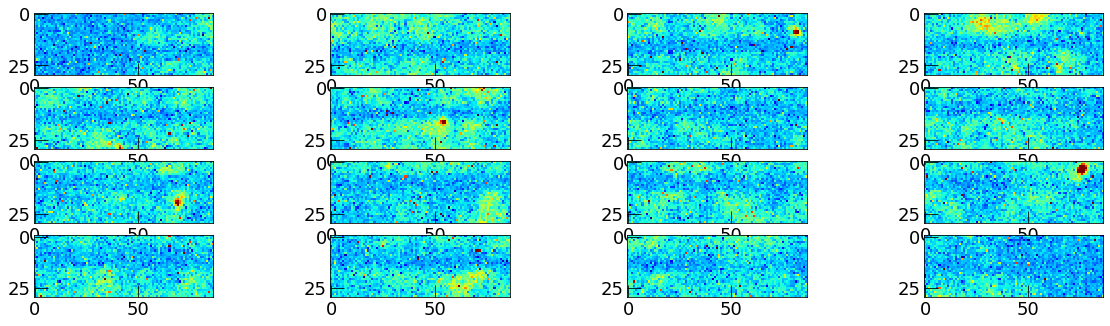

Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...
Unable to fit data...


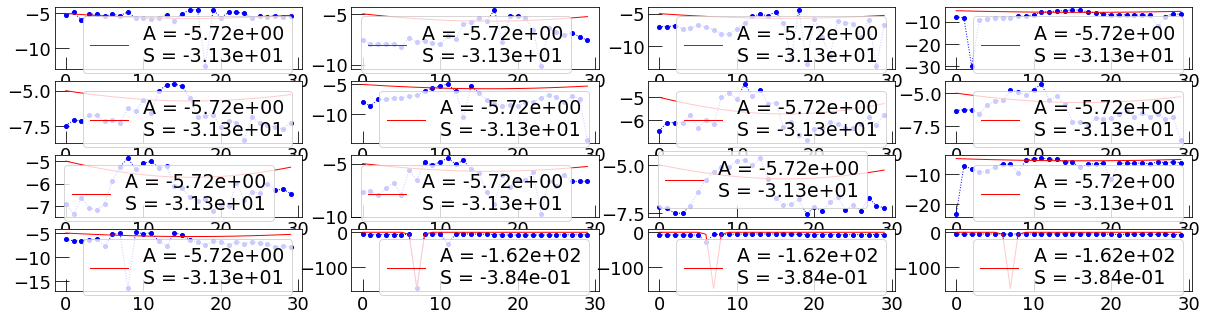

In [221]:
nslide    = 4
fitVar    = np.ndarray((nslide*nslide, 3), dtype=np.float64)
dy0 = imageCutted.shape[0]

slide     = np.int(imageCutted.shape[1]/(nslide*nslide))
f, axarr  = plt.subplots(nslide, nslide)
e_slide   = 0
xs = np.arange(0, dy0)
for j in range(0, nslide):
    for k in range(0, nslide):
        s_slide = e_slide 
        e_slide = s_slide + slide
        axarr[j, k].imshow(imageCutted[0:,s_slide:e_slide], vmin=cimin,vmax=cimax, cmap='jet')

plt.show()
f, axarr  = plt.subplots(nslide, nslide)
e_slide   = 0

ji        = 0

for j in range(0, nslide):
    for k in range(0, nslide):
        s_slide = e_slide 
        e_slide = s_slide + slide
        y  = np.mean(105-imageCutted[0:,s_slide:e_slide], axis=1)
        a0 = Afit[0]
        x0 = Afit[1]
        s0 = Afit[2]
        try:
            popt,pcov = curve_fit(my.Gauss3, xs, y, p0=[a0, x0, s0])
            perr = np.sqrt(np.diag(pcov))
            # print perr
        except:
            print("Unable to fit data...")

        axarr[j, k].plot(xs, y, 'b:.')
        axarr[j, k].plot(xs, my.Gauss3(xs, *popt), 'r-', label='A = %.2e\nS = %.2e' % (popt[0], popt[2]))
        axarr[j, k].legend()
        fitVar[ji,] = popt
        ji+=1
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


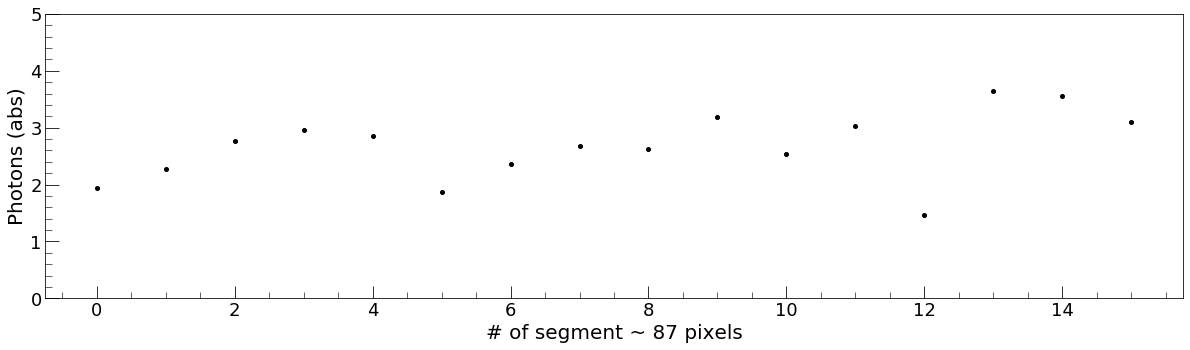

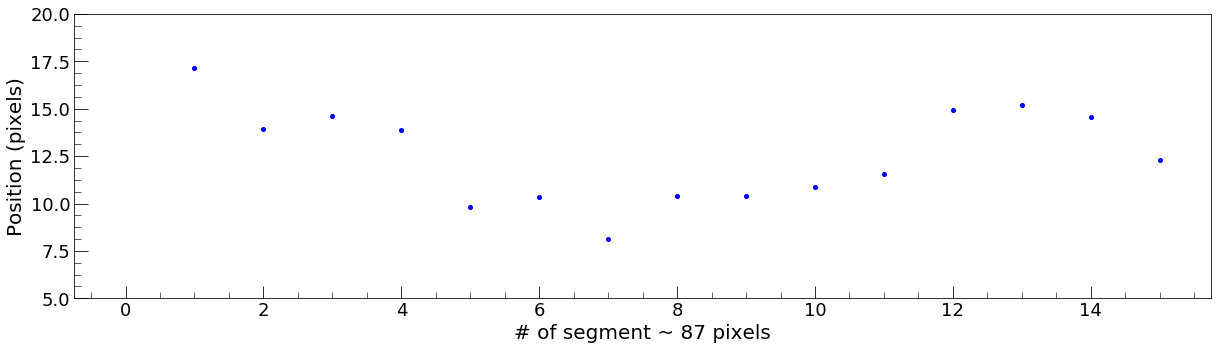

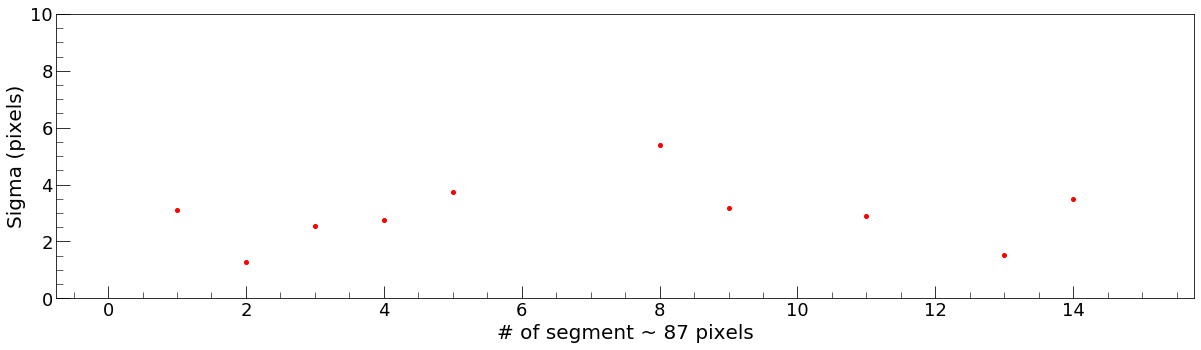

In [197]:
y = abs(fitVar[:,0])
x = np.arange(0, y.shape[0])
plt.plot(x, y, "k.")
plt.ylabel('Photons (abs)')
plt.xlabel('# of segment ~ %d pixels' % slide)
plt.ylim(0,5)
plt.minorticks_on()
plt.show()
y = abs(fitVar[:,1])
x = np.arange(0, y.shape[0]) 
plt.plot(x, y, "b.")
plt.ylabel('Position (pixels)')
plt.xlabel('# of segment ~ %d pixels' % slide)
plt.minorticks_on()
plt.ylim(5,20)
plt.show()
y = abs(fitVar[:,2])
x = np.arange(0, y.shape[0]) 
plt.plot(x, y, "r.")
plt.ylabel('Sigma (pixels)')
plt.xlabel('# of segment ~ %d pixels' % slide)
plt.minorticks_on()
plt.ylim(0,10)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


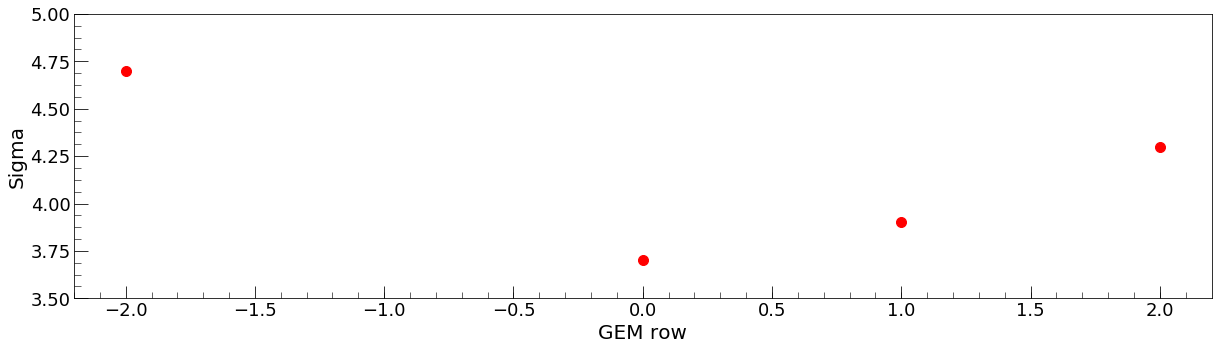

In [162]:
y = np.array([4.7,6.7,3.7,3.9,4.3])
x = np.arange(-2, y.shape[0]/2)
plt.plot(x, y, "r.", markersize=20)
plt.ylabel('Sigma')
plt.xlabel('GEM row')
plt.ylim(3.5,5)
plt.minorticks_on()
plt.show()